In [1]:
import numpy as np
import visa
import matplotlib.pyplot as plt
import time
from lantz import MessageBasedDriver, Q_
from lantz.core import Feat
from lantz.core import mfeats
from lantz import ureg
import sounddevice as sd
from scipy import signal as sg

In [2]:
class Generador(MessageBasedDriver):
#    def __init__(self,ID):
#        self.obj_visa=rm.open_resource(ID)
#        self.ID = ID
    set_query = MessageBasedDriver.write
    # Feats punciona como un property, pero ademas acepta otras opciones
    @Feat()
    def idn(self):
        return self.query('*IDN?')

    # La idea es no usar sets and gets como metodos, sino definir propiedades
        
    frequency = mfeats.QuantityFeat('SOURce1:FREQuency:FIXed?','SOURce1:FREQuency:FIXed {}',units='Hz',limits=(0.0,1000000))
    amplitude = mfeats.QuantityFeat('SOURce1:VOLT:LEV:IMM:AMPL?','SOURce1:VOLT:LEV:IMM:AMPL {}',units='V',limits=(0.05,5))
    offset = mfeats.QuantityFeat('SOURce1:VOLT:LEV:IMM:OFFS?','SOURce1:VOLT:LEV:IMM:OFFS {}',units='V',limits=(0,10))
        
    def setWaveform(self,waveform ='Senoidal'):
        switcher = {'Senoidal':"SIN",'Cuadrada':"SQU",'Pulso':"PULS"}
        self.write("SOURce1:FUNCtion "+switcher.get(waveform,'Senoidal'))  

        
class Osciloscopio(MessageBasedDriver):

    set_query = MessageBasedDriver.write
    
    @Feat()
    def idn(self):
        return self.query('*IDN?')

    timebase = mfeats.QuantityFeat('HORizontal:MAIN:SCALe?','HORizontal:MAIN:SCALe {}',units='s')
    vertical_scale = mfeats.QuantityFeat('CH1:SCA?','CH1:SCA {}',units='V')

    def vpp(self):
        osci.write('MEASUrement:IMMed:TYPE PK2pk')
        return float(osci.query('MEASUREMENT:IMMed:VALue?'))

    def mean(self):
        osci.write('MEASUrement:IMMed:TYPE MEAN')
        return float(osci.query('MEASUREMENT:IMMed:VALue?')) 
    
    @Feat()
    def capturaPantalla(self):
 #       if self.parameters is None:
        YOFF_in_dl = float(self.query("WFMP:YOFF?"))
        YZERO_in_YUNits = float(self.query("WFMP:YZERO?"))
        YMUlt = float(self.query("WFMP:YMULT?"))
        print(YOFF_in_dl,YZERO_in_YUNits,YMUlt)
     #   self.parameters = (YOFF_in_dl,YZERO_in_YUNits,YMUlt)
      #  (YOFF_in_dl , YZERO_in_YUNits , YMUlt) = self.parameters
        curve_in_dl = np.array(self.query('CURV?'))#, datatype='b', is_big_endian=True))
        valores = ((curve_in_dl - YOFF_in_dl)*YMUlt)+YZERO_in_YUNits
        intervalo = float(osci.query('WFMPre:XINcr?'))
        tiempos = np.arange(len(valores))*intervalo
        return tiempos, valores

In [3]:
rm = visa.ResourceManager()
ID=rm.list_resources()
genf = Generador(ID[0])
#osci = Osciloscopio(ID[1])
ID

('USB0::0x0699::0x0363::C065092::INSTR',)

In [4]:
def Senoidal(Offs,Ampl,Freq,nPeriods):
    n=nPeriods
    SR = sd.default.samplerate
    t = np.linspace(0,n*np.divide(1,Freq),n*int(np.divide(SR,Freq)),endpoint=False) # valores de tiempo que van a ser barridos.
    return t,np.divide(Ampl*np.sin(2*np.pi*Freq*t)+Offs,1.6)

def Cuadrada(Offs,Ampl,Freq):
    n=1 # Num de periodos fijo
    SR = sd.default.samplerate
    t = np.linspace(0,n*np.divide(1,Freq),n*int(np.divide(SR,Freq)),endpoint=False) # valores de tiempo que van a ser barridos.
    lista = []
    for i in t:
        if i<np.divide(1,2*Freq):
            lista.append(-1)
        else:
            lista.append(1)
    salida = np.asarray(lista)   
    return t,np.divide(Ampl*salida+Offs,1.6)

def Squared(Offs,Ampl,Freq,nPeriods):
    n=nPeriods
    SR = sd.default.samplerate
    t = np.linspace(0,n*np.divide(1,Freq),n*int(np.divide(SR,Freq)),endpoint=False) # valores de tiempo que van a ser barridos.
    return t,np.divide(Ampl*sg.square(2*np.pi*Freq*t)+Offs,1.6)    
    

def PlaySin(Ampl,Freq,Time):
    t,y=Senoidal(Ampl,Freq,1)
    sd.play(y,loop=True)
    time.sleep(Time)
    sd.stop()

In [5]:
sd.default.samplerate=11025
sd.default.latency = ['high','high']

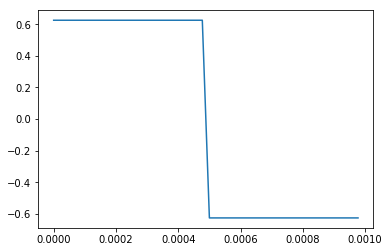

In [49]:
Freq = 1000
#t,y=Senoidal(0,01.6,Freq,1)
t,y=Squared(0,1,Freq,1)
#t,y=Cuadrada(0,1,Freq)
plt.plot(t,y,'-')

sd.play(y,loop=True)

In [8]:
sd.query_devices()

  0 Asignador de sonido Microsoft - Input, MME (2 in, 0 out)
> 1 Micrófono (Dispositivo de High , MME (2 in, 0 out)
  2 Asignador de sonido Microsoft - Output, MME (0 in, 2 out)
< 3 Auriculares (Dispositivo de Hig, MME (0 in, 2 out)
  4 Altavoces (Dispositivo de High , MME (0 in, 2 out)
  5 Headphones (Auricular de HD Audio), Windows WDM-KS (0 in, 2 out)
  6 Micrófono (Micrófono de HD Audio), Windows WDM-KS (2 in, 0 out)
  7 Speakers (Altavoz de HD Audio), Windows WDM-KS (0 in, 2 out)

In [12]:
sd.stop()

In [24]:
sd.default.device = [4,5]

In [8]:
Freq = 1000
N=10000
t,y=Senoidal(0,.5,Freq,1)
#sd.play(y,loop=True)
#myrecording = sd.playrec(y, channels=2,blocking=True)
#time.sleep(2)
myrecording = sd.rec(N,channels=2,blocking=True)
#time.sleep(15)
ch1=np.asarray([i[0] for i in myrecording])
ch2=np.asarray([i[1] for i in myrecording])
tiempo = np.divide(np.arange(len(ch1)),sd.default.samplerate)


(0, 4000)

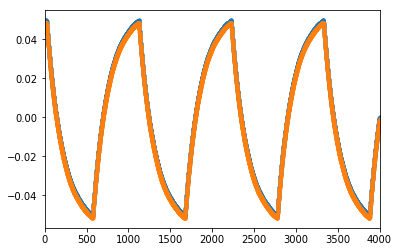

In [11]:
plt.plot(ch1,'.',markersize=6)
plt.plot(ch2,'.',markersize=6)
#plt.plot(medicion)
#plt.plot((ch1),'.',markersize=4)
#plt.plot((ch2),'.',markersize=4)
plt.xlim(0,4000)
#plt.ylim(0.06,.08)

In [ ]:
Estabamos  tratando de forzar la señal d